# Tutorial on using the Platform

This is the tutorial bla bla bla

## Initialization

First we need to import the necessary class blabla bla

In [1]:
from qEmQUIP import QEM, conf
import sys, glob, os
from commons import convert_to_json, triq_optimization, qiskit_optimization, \
    calibration_type_enum, qiskit_compilation_enum, normalize_counts, calculate_success_rate_tvd
import wrappers.qiskit_wrapper as qiskit_wrapper
from wrappers.qiskit_wrapper import QiskitCircuit

Here we need to initialize the object, please check the `config.ini` file to update the general config

In [2]:
# Put your Qiskit Token
token = "74076e69ed0d571c8e0ff8c0b2c912c28681d47426cf16a5d817825de16f7dbd95bf6ff7c604b706803b78b2e21d1dd5cacf9f1b0aa81d672d938bded8049a17"
q = QEM(runs=conf.runs, fixed_initial_layout = False, run_in_simulator=conf.run_in_simulator, user_id=conf.user_id, token=token)

## Prepare the circuits

You can get the quantum circuit from a folder contains the qasm files or qasm string

In [3]:
# The path is coming from the config file, but you can also modify it here
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()
print(qasm_files)

['./circuits/testing/adder_n4.qasm']


Get the circuits from file

In [4]:
qc = q.get_circuit_properties(qasm_source=qasm_files[0])
qc.circuit.draw(idle_wires=False)

┌───────────┐ ┌─────────────┐                          ┌───┐     »
q_0: ─┤ U3(π,0,π) ├─┤ U3(0,0,π/4) ├───────■──────────────────┤ X ├──■──»
      ├───────────┤ ├─────────────┤     ┌─┴─┐                └─┬─┘┌─┴─┐»
q_1: ─┤ U3(π,0,π) ├─┤ U3(0,0,π/4) ├─────┤ X ├─────────────■────┼──┤ X ├»
      └───────────┘ └─────────────┘┌────┴───┴────┐      ┌─┴─┐  │  └───┘»
q_2: ──────────────────────■───────┤ U3(0,0,π/4) ├───■──┤ X ├──┼────■──»
     ┌─────────────┐     ┌─┴─┐     ├─────────────┴┐┌─┴─┐└───┘  │  ┌─┴─┐»
q_3: ┤ U3(π/2,0,π) ├─────┤ X ├─────┤ U3(0,0,-π/4) ├┤ X ├───────■──┤ X ├»
     └─────────────┘     └───┘     └──────────────┘└───┘          └───┘»
c: 4/══════════════════════════════════════════════════════════════════»
                                                                       »
«     ┌──────────────┐                          ┌───┐               ┌─┐   
«q_0: ┤ U3(0,0,-π/4) ├──■───────────────────────┤ X ├───────────────┤M├───
«     ├──────────────┤┌─┴─┐               ┌─┐   └─┬─┘               └╥┘   
«q_1: ┤ U3(0,0,-π/4) ├┤ X ├───────────────┤M├─────┼──────────────────╫────
«     ├──────────────┤└───┘               └╥┘┌─┐  │                  ║    
«q_2: ┤ U3(0,0,-π/4) ├──■──────────────────╫─┤M├──┼──────────────────╫────
«     ├─────────────┬┘┌─┴─┐┌─────────────┐ ║ └╥┘  │  ┌─────────────┐ ║ ┌─┐
«q_3: ┤ U3(0,0,π/4) ├─┤ X ├┤ U3(0,0,π/2) ├─╫──╫───■──┤ U3(π/2,0,π) ├─╫─┤M├
«     └─────────────┘ └───┘└─────────────┘ ║  ║      └─────────────┘ ║ └╥┘
«c: 4/═════════════════════════════════════╩══╩══════════════════════╩══╩═
«                                          1  2                      0  3

Or you can also get it from the qasm strings

In [5]:
qasm_text = """OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
creg c[4];
h q[0];
cx q[0], q[1];
cx q[1], q[2];
cx q[2], q[3];
barrier q[0], q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
"""

qc = q.get_circuit_properties(qasm_source=qasm_text)
qc.circuit.draw(idle_wires=False)

┌─────────────┐            ░  ┌─┐         
q_0: ┤ U3(π/2,0,π) ├──■─────────░──┤M├─────────
     └─────────────┘┌─┴─┐       ░  └╥┘┌─┐      
q_1: ───────────────┤ X ├──■────░───╫─┤M├──────
                    └───┘┌─┴─┐  ░   ║ └╥┘┌─┐   
q_2: ────────────────────┤ X ├──■───╫──╫─┤M├───
                         └───┘┌─┴─┐ ║  ║ └╥┘┌─┐
q_3: ─────────────────────────┤ X ├─╫──╫──╫─┤M├
                              └───┘ ║  ║  ║ └╥┘
c: 4/═══════════════════════════════╩══╩══╩══╩═
                                    0  1  2  3

`q.get_circuit_properties` will give an object of `QiskitCircuit` which will give the information of the circuits: 
- `circuit`: `QuantumCircuit` object from Qiskit
- `depth`: circuit depth
- `gates`: number of gates used in the circuit
- `total_gates`: number of total gates used in the circuit
- `correct_output`: noiseless output from the simulation
- `qasm`: OpenQASM2 file from the circuit translated to `U3` and `cx` gates
- `qasm_original`: OpenQASM2 file from the circuit original


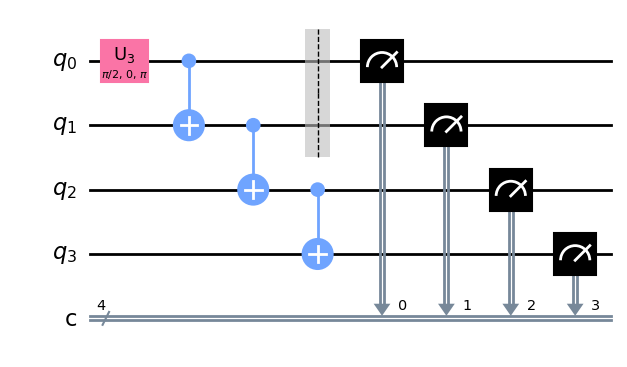

In [6]:
qc.circuit.draw("mpl")

In [7]:
print("Number of depth:", qc.depth)
print("Number of gates:", qc.gates)
print("Number of total gates:", qc.total_gate) 
print("Noiseless simulation output:", qc.correct_output)
print("Circuit Qasm:", qc.qasm)

Number of depth: 5
Number of gates: {'measure': 4, 'cx': 3, 'u3': 1, 'barrier': 1}
Number of total gates: 5
Noiseless simulation output: {'15': 0.5065, '0': 0.4935}
Circuit Qasm: OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
creg c[4];
u3(pi/2,0,pi) q[0];
cx q[0],q[1];
cx q[1],q[2];
barrier q[0],q[1];
cx q[2],q[3];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];



## Compilation Techniques

### Qiskit

We integrated several compilation techniques from Qiskit

In [8]:
print("Existing Qiskit Compilation Options:")
for member in qiskit_compilation_enum:
    print(member.name)

Existing Qiskit Compilation Options:
qiskit_0
qiskit_3
qiskit_NA_avg
qiskit_NA_lcd
qiskit_NA_mix
qiskit_NA_w15
qiskit_NA_avg_adj
qiskit_NA_lcd_adj
qiskit_NA_mix_adj
qiskit_NA_w15_adj
qiskit_NA_wn
qiskit_NA_wn_adj
mapomatic_lcd
mapomatic_avg
mapomatic_mix
mapomatic_avg_adj
mapomatic_w15_adj


In [9]:
updated_qasm = q.compile(qasm=qc.qasm_original, compilation_name=qiskit_compilation_enum.qiskit_NA_lcd.value)
print(updated_qasm)

OPENQASM 2.0;
include "qelib1.inc";
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }
gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
qreg q[127];
creg c[4];
rz(pi/2) q[37];
sx q[37];
rz(-0.9657822870720683) q[37];
rz(-pi/2) q[38];
sx q[38];
rz(2.339468643966633) q[38];
rz(pi/2) q[39];
sx q[39];
rz(-0.39374052556949124) q[39];
sx q[39];
rz(pi/2) q[39];
rz(pi/2) q[40];
sx q[40];
rz(1.6817720802165583) q[40];
ecr q[40],q[39];
rz(-0.8660471557214651) q[39];
sx q[39];
rz(-0.49926687928477875) q[39];
sx q[39];
rz(-2.500252093349383) q[39];
ecr q[38],q[39];
rz(-2.3729203364180584) q[38];
sx q[38];
rz(-0.10130223871172284) q[38];
sx q[38];
rz(-pi/2) q[38];
ecr q[37],q[38];
rz(0.6050140397228279) q[37];
sx q[37];
rz(-pi/2) q[37];
rz(pi/2) q[38];
sx q[38];
rz(3.0402904148780703) q[38];
rz(-pi/2) q[39];
sx q[39];
rz(1.8861739403284155) q[39];
x q[40];
rz(-1.6817720802165592) q[40];
barrier q[40],q[39],q[38],q[37];
measure q[40] -> c[0];
measure q[39] -> c[1];


### TriQ

Also, we integrate TriQ Compilation with different options.

Qubit placement options:
- `na`: initial mapping from Noise-adaptive technique []
- `mapo`: initial mapping from Mapomatic technique []
- `sabre`: initial mapping from SABRE []

Calibration type options:
- `lcd` : TriQ's routing with last calibration data.
- `avg` : TriQ's routing with average calibration data.
- `mix` : TriQ's routing with mix calibration data. (Mix = if the qubits calibrated today, we will use the last calibration data for that qubit, otherwise we will use the average)
- `w15` : TriQ's routing with average calibration data of 15 days from the qubit is compiled.

The combinations of name become: `triq_<calibration_type>_<layout>`. For examples:
- `triq_avg_na`
- `triq_mix_sabre`

In [10]:
updated_qasm = q.compile(qasm=qc.qasm_original, compilation_name="triq_avg_na")
print(updated_qasm)

Initial mapping path : 104, 103, 101, 100
OPENQASM 2.0;
include "qelib1.inc";
qreg q[127];
creg c[127];
u2(0,3.14159265358979) q[104];
cx q[104],q[103];
cx q[103],q[102];
cx q[102],q[103];
cx q[103],q[102];
cx q[102],q[101];
cx q[101],q[100];
measure q[104] -> c[0];
measure q[101] -> c[2];
measure q[102] -> c[1];
measure q[100] -> c[3];



## Initiate Noisy simulator

To play around with the noise, we can get retrieve the last recorded calibration data from IBM's backend, and scale down the error


In [11]:
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)

## Running the compiled circuit to the simulator

First, we need to transpile the circuit to the targeted backend

In [12]:
qc = QiskitCircuit(updated_qasm)
circuit = qc.transpile_to_target_backend(q.backend, False)
# circuit.draw("mpl", idle_wires=False, fold=60)

In [13]:
job = noisy_simulator.run(circuit, shots=10000)
result = job.result()  
output = result.get_counts()
output_normalize = normalize_counts(output, shots=10000)
# output_normalize

## Calculate the Fidelity

In [14]:
calculate_success_rate_tvd(qc.correct_output,output_normalize)

0.8623000000000001

## Put them together

In [ ]:
res_circuit_name = []
res_compilations = []
res_noise_levels = []
res_success_rate = []

# prepare the circuit
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()

shots = 10000

# select compilation techniques
# compilations = ["qiskit_0", "qiskit_3", "qiskit_NA_avg", "triq_avg_na"]
compilations = ["qiskit_3", "triq_lcd_na"]

# select the noise levels (0 = noiseless, 1 = noise model from real backend)
noise_levels = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

for qasm in qasm_files:
    for comp in compilations:
        for noise in noise_levels:
            qc = q.get_circuit_properties(qasm_source=qasm)
            circuit_name = qasm.split("/")[-1].split(".")[0]
    
            updated_qasm = q.compile(qasm=qc.qasm_original, compilation_name=comp)
            compiled_qc = QiskitCircuit(updated_qasm)
            circuit = compiled_qc.transpile_to_target_backend(q.backend, False)
            
            noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, noise)

            job = noisy_simulator.run(circuit, shots=shots)
            result = job.result()  
            output = result.get_counts()
            output_normalize = normalize_counts(output, shots=shots)

            tvd = calculate_success_rate_tvd(qc.correct_output,output_normalize)
            print(comp, noise, tvd)

        


qiskit_3 0 1.0
qiskit_3 0.1 0.971


In [ ]:
qc.gates